In [1]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import matplotlib.colors as mcolors
import matplotlib as mpl

In [ ]:
# Extract command parameters from a string
def extract_params(command, params):
    param_dict = {}
    command_split = command.split()
    for param in params:
        if param in command_split:
            param_index = command_split.index(param)
            param_value = command_split[param_index + 1]
            param_dict[param] = param_value
    return param_dict

In [ ]:
wandb.login()
api = wandb.Api()
runs = api.runs('ten-harvard/QM9-clean-experiments')

runs_data = []
# Parameters to extract from the config
params_to_extract = ['lifters', 'initial_features', 'neighbor_types', 'connectivity']

In [ ]:
for run in runs:
    config = run.config
    summary = run.summary._json_dict

    run_data = {
        'run_id': run.id,
        'target_name': config.get('target_name'),
        'test_mae': summary.get('Test MAE'),  
        'run_name': config.get('run_name'),   
        'interval_test_mae': summary.get('Interval Test MAE')  
    }

    for param in params_to_extract:
        param_value = config.get(param)
        if isinstance(param_value, list):
            param_value = ','.join(map(str, param_value))
        run_data[param] = str(param_value)  

    runs_data.append(run_data)

In [72]:
##### Dataframe from runs ######

df = pd.DataFrame(runs_data)
# Extract the configuration name from the run_name, handling None values
df['config_name'] = df['run_name'].apply(lambda x: x.split()[0] if x else None)
df['config_name_numeric'] = pd.to_numeric(df['config_name'], errors='coerce')
# Fill NaN values in test_mae with interval_test_mae
df['clean_test_mae'] = df['test_mae'].fillna(df['interval_test_mae'])

# Drop rows with NaN values in clean_test_mae or config_name or parameters
df = df.dropna(subset=['clean_test_mae'])
df = df.dropna(subset=['config_name_numeric'])
df = df.dropna(subset=params_to_extract)


# Convert categorical columns to strings and numerical columns to float
for param in params_to_extract:
    if df[param].dtype == 'object':
        df[param] = df[param].astype(str)
    else:
        df[param] = df[param].astype(float)


# Encode each parameter, so that it does not have categorical variables (will help for parallel coordinates plot)
encoders = {param: LabelEncoder() for param in params_to_extract}
for param in params_to_extract:
    df[param] = encoders[param].fit_transform(df[param].astype(str))



/var/folders/mr/qlm7w5m16_sczbgk81x727yr0000gn/T/ipykernel_29248/3332417208.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_target['norm_test_mae'] = (df_target['clean_test_mae'] - df_target['clean_test_mae'].min()) / (df_target['clean_test_mae'].max() - df_target['clean_test_mae'].min())
/var/folders/mr/qlm7w5m16_sczbgk81x727yr0000gn/T/ipykernel_29248/3332417208.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_target['norm_test_mae'] = (df_target['clean_test_mae'] - df_target['clean_test_mae

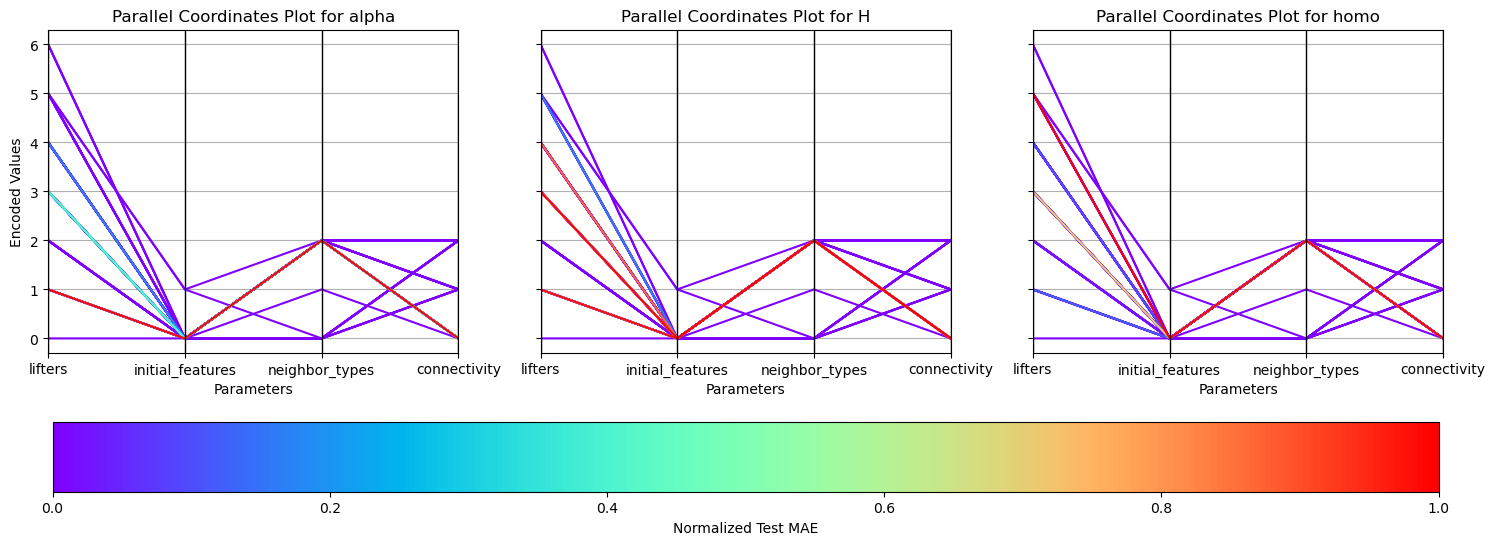

In [67]:
##### Parallel Coordinates Plot ######

# List of targets
targets = ['alpha', 'H', 'homo']

# Create subplots
fig, axes = plt.subplots(1, len(targets), figsize=(18, 6), sharey=True)

# Iterate over targets and create parallel coordinates plot for each
for i, target_name_filter in enumerate(targets):
    df_target = df[df['target_name'] == target_name_filter]
    df_target['norm_test_mae'] = (df_target['clean_test_mae'] - df_target['clean_test_mae'].min()) / (df_target['clean_test_mae'].max() - df_target['clean_test_mae'].min())
    # Sort the dataframe by clean_test_mae to ensure smooth color transition
    df_target = df_target.sort_values(by='norm_test_mae')

    # Define the color map
    cmap = plt.get_cmap('rainbow')
    norm = mcolors.Normalize(vmin=df_target['norm_test_mae'].min(), vmax=df_target['norm_test_mae'].max())
    colors = cmap(norm(df_target['norm_test_mae']))

    # Plot using the parallel_coordinates function
    ax = axes[i]
    parallel_coordinates(df_target, class_column='norm_test_mae', cols=params_to_extract, color=colors, ax=ax)

    # Customize the plot
    ax.set_title('Parallel Coordinates Plot for ' + target_name_filter)
    ax.set_xlabel('Parameters')
    if i == 0:
        ax.set_ylabel('Encoded Values')
    ax.grid(True)
    ax.legend_.remove()

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=axes.ravel().tolist(), orientation='horizontal')
cbar.set_label('Normalized Test MAE')

# plt.tight_layout()
plt.show()

In [75]:
##### Runs to Latex Table ######

df['config_name'] = df['config_name'].astype(int)

# Keep the entry with the lowest clean_test_mae for each (config_name, target_name) pair
idx = df.groupby(['config_name', 'target_name'])['clean_test_mae'].idxmin()
df_unique = df.loc[idx]

# Pivot the DataFrame to create the LaTeX table format
pivot_df = df_unique.pivot(index='config_name', columns='target_name', values='clean_test_mae')

# Multiply specific targets by 1000 and convert to integers
multiply_targets = ['gap', 'homo', 'lumo', 'G', 'H', 'U', 'U0']
pivot_df[multiply_targets] = pivot_df[multiply_targets] * 1000
pivot_df[multiply_targets] = pivot_df[multiply_targets].astype(int)

# Define the new order of target names for the two tables
first_table_columns = ['alpha', 'gap', 'homo', 'lumo', 'mu', 'Cv']
second_table_columns = ['G', 'H', 'r2', 'U', 'U0', 'zpve']

# Reindex the pivoted DataFrame to rearrange the columns
pivot_df_first = pivot_df.reindex(columns=first_table_columns)
pivot_df_second = pivot_df.reindex(columns=second_table_columns)

# Define a custom formatter to remove zeros before the dot
def custom_format(x):
    if isinstance(x, int):
        return str(x)
    elif isinstance(x, float):
        return ('%.3f' % x).lstrip('0').rstrip('0').rstrip('.')
    else:
        return str(x)

latex_table_1 = pivot_df_first.to_latex(float_format=custom_format, na_rep="NaN")
latex_table_2 = pivot_df_second.to_latex(float_format=custom_format, na_rep="NaN")

with open('clean_test_mae_table_part1.tex', 'w') as file:
    file.write(latex_table_1)

with open('clean_test_mae_table_part2.tex', 'w') as file:
    file.write(latex_table_2)

# Print the LaTeX tables
print("First LaTeX Table:")
print(latex_table_1)

print("Second LaTeX Table:")
print(latex_table_2)

First LaTeX Table:
\begin{tabular}{lrrrrrr}
\toprule
target\_name &  alpha &  gap &  homo &  lumo &   mu &   Cv \\
config\_name &        &      &       &       &      &      \\
\midrule
1           &   .074 &   46 &    30 &    24 &  .03 & .032 \\
2           &   .078 &   50 &    32 &    25 & .029 & .032 \\
3           &   .079 &   50 &    34 &    25 & .029 & .033 \\
4           &   .077 &   54 &    31 &    27 & .032 & .033 \\
5           &   .066 &   48 &    27 &    25 &  .03 & .033 \\
6           &    .07 &   47 &    26 &    23 & .023 &  .03 \\
7           &   .072 &   47 &    27 &    23 & .024 & .032 \\
8           &   .071 &   49 &    26 &    23 & .023 & .032 \\
9           &   .069 &   46 &    26 &    23 & .025 & .033 \\
10          &   .157 &   72 &    45 &    46 &  .31 & .053 \\
11          &   .149 &   69 &    45 &    45 & .298 & .048 \\
12          &    .07 &   45 &    28 &    23 & .029 & .035 \\
13          &    .07 &   49 &    28 &    25 &  .03 & .036 \\
14          &    .13 

/var/folders/mr/qlm7w5m16_sczbgk81x727yr0000gn/T/ipykernel_29248/1355841826.py:34: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table_1 = pivot_df_first.to_latex(float_format=custom_format, na_rep="NaN")
/var/folders/mr/qlm7w5m16_sczbgk81x727yr0000gn/T/ipykernel_29248/1355841826.py:35: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table_2 = pivot_df_second.to_latex(float_format=custom_format, na_rep="NaN")
